In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from fastai.vision.all import *
from torchvision import transforms
import torchvision.transforms.functional as TF
import ipywidgets as widgets
from PIL import Image as pilImage


In [3]:
ROOT_DIR =  Path('../')
DATA_PATH = ROOT_DIR/'data/'
IMGS_PATH = ROOT_DIR/'imgs/'

In [4]:
path = untar_data(URLs.IMAGENETTE_160,dest=DATA_PATH)
path

Path('../data/imagenette2-160')

In [5]:
(path/'train').ls()

(#10) [Path('../data/imagenette2-160/train/n03394916'),Path('../data/imagenette2-160/train/n03417042'),Path('../data/imagenette2-160/train/n03445777'),Path('../data/imagenette2-160/train/n02102040'),Path('../data/imagenette2-160/train/n03425413'),Path('../data/imagenette2-160/train/n03888257'),Path('../data/imagenette2-160/train/n03028079'),Path('../data/imagenette2-160/train/n03000684'),Path('../data/imagenette2-160/train/n01440764'),Path('../data/imagenette2-160/train/n02979186')]

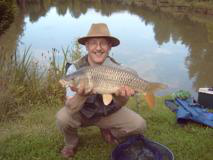

In [6]:
fname = (path/"train/n01440764").ls()[0]
PILImage.create(fname)

In [7]:
def np_to_tensor(img):
    return torch.Tensor(img).permute(2,0,1).float()/255.0
def tensor_to_img(img):
    return (img.permute(1,2,0).numpy()*255.0).astype('uint8')

def imresize(arr, sz):
    height, width = sz
    return np.array(arr_to_img(arr).resize((width, height), resample=pilImage.BILINEAR))

def arr_to_img(img, cmap=None):
    def normalize(x): 
        return (x-x.min())/(x.max()-x.min())
    if cmap is not None:
        cm = plt.get_cmap(cmap)
        img = cm(img)[:,:,:3]
    return PILImage.create((normalize(img)*255).astype('uint8'))

# Show linear layer activation function
def show_1D_act(act):
    '''Show activation visualizations of the l-th linear layer with figsize s*s'''
    act_length = act.shape[-1]
    act = act.numpy() if type(act)!=np.ndarray else act
    act = np.array([[act],]*20).reshape(20,act.shape[-1]) # copy linear activation 20x for better visualization
    act = arr_to_img(imresize(act, (20,400)))
    #act = arr_to_img(act).resize((20,5),resample=pilImage.BILINEAR)
    fig, ax = plt.subplots(figsize=(10,1))
    ax.imshow(act, cmap='inferno')
    ax.set_axis_off()

In [8]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)

Using cache found in /Users/ap/.cache/torch/hub/pytorch_vision_v0.6.0


In [15]:
import urllib.request, json 
with urllib.request.urlopen('https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json') as url:
    classes = json.loads(url.read().decode())
f_to_idx = {val[0]:idx for idx,val in classes.items()}
my_classes = [f_to_idx[f.name] for f in (path/"train").ls()]


In [17]:
{i:classes[i] for i in my_classes}

{'566': ['n03394916', 'French_horn'],
 '569': ['n03417042', 'garbage_truck'],
 '574': ['n03445777', 'golf_ball'],
 '217': ['n02102040', 'English_springer'],
 '571': ['n03425413', 'gas_pump'],
 '701': ['n03888257', 'parachute'],
 '497': ['n03028079', 'church'],
 '491': ['n03000684', 'chain_saw'],
 '0': ['n01440764', 'tench'],
 '482': ['n02979186', 'cassette_player']}

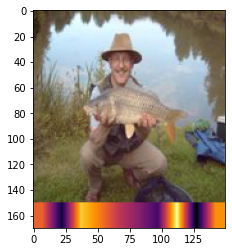

In [24]:
class MyImg():
    def __init__(self,img,model=None,get_model_act=False,restrict_classes=None):
        self.img_orig = img.copy()
        self.img = img.copy()
        self.x_orig = np_to_tensor(img).unsqueeze(0)
        self.x = np_to_tensor(img).unsqueeze(0)
        self.model = model
        self.get_model_act = get_model_act
        self.images = []
        self.activations = []
        self.restrict_classes = restrict_classes
        
    def reset(self):
        self.img = self.img_orig.copy()
        self.x = self.x_orig # does this work without some kind of copy ? in tfms() it seems to work
        self.images = []
        self.activations = []
        
    def tfm_brightness(self, brightness, show=False):
        x =  TF.adjust_brightness(self.x, brightness)
        if show:
            plt.imshow(tensor_to_img(x[0]))
        return x
    
    def tfm_centercrop(self, crop_size, show=False):
        x =  transforms.CenterCrop(crop_size)(self.x)
        if show:
            plt.imshow(tensor_to_img(x[0]))
        return x  
    
    def tfms(self, brightness=None, crop_size=None, show=True):
        self.x = self.x_orig#.copy()
        if brightness is not None:
            self.x = self.tfm_brightness(brightness)
        if crop_size is not None:
            self.x = self.tfm_centercrop(crop_size)
        
        if self.get_model_act:
            out = self.model(self.x).detach().numpy()
            if self.restrict_classes is not None:
                out = out[:,self.restrict_classes]
            self.activations.append(out)
            img = self.combine_activation_with_img(out)
        else:
            img = tensor_to_img(self.x[0])
        self.images.append(img)
        if show:
            plt.imshow(img)
         
    def combine_activation_with_img(self, out):
        # to make flatten activation better visible, the images will be streched by a factor of 20 
        # and the width is adapted to the original image width
        shape = (20,self.x.shape[2])
        transform_act = lambda x: arr_to_img(imresize(x,shape), 'inferno') 

        # combine transformed images and their layer activations
        img_comb = np.vstack([tensor_to_img(self.x[0]), transform_act(out) ])
        return img_comb
    
    def create_gif(self,path): 
        # to make flatten activation better visible, the images will be streched by a factor of 20 and the width is adapted to the original image width
        w,h,d = self.images[0].shape
        transform_act = lambda x: arr_to_img(imresize(x,(20,w)), 'inferno') 

        # combine sequence of transformed images and their layer activations
        imgs_combs = [ np.vstack([arr_to_img(img).resize((w,h)), transform_act(act) ]) for img, act in zip(self.images,self.activations)  ]

        # transform to images, add backward loop and store as gif
        first_img, *imgs = [ pilImage.fromarray( img ) for img in imgs_combs]
        imgs += [img for img in imgs[::-1]]
        first_img.save(fp=path, format='GIF', append_images=imgs, save_all=True, duration=100, loop=0)


size = 160
img = PILImage.create(fname).resize((size,size))
myimg = MyImg(np.array(img),model,get_model_act=True,restrict_classes=list(map(int,my_classes)))
myimg.tfms(crop_size=150)

In [25]:
import ipywidgets as widgets
slider_brightness = widgets.FloatSlider(value=1,min=0.1,max=4,stepsize=0.2)
slider_crop_size = widgets.IntSlider(value=100,min=33,max=160,stepsize=5)

In [26]:
def create_gif_on_click(change):
    myimg.create_gif(IMGS_PATH/'test2.gif')
    #out_pl.clear_output()
    #with out_pl: display(img.to_thumb(128,128))
btn_create_gif = widgets.Button(description='Create gif')
btn_create_gif.on_click(create_gif_on_click)

In [27]:
myimg.reset()
out_tfms = widgets.interactive_output(myimg.tfms, {"brightness":slider_brightness,"crop_size":slider_crop_size})
#out_tfms.clear_output()
widgets.HBox([widgets.VBox([slider_brightness,slider_crop_size,btn_create_gif]), out_tfms])

[SegmentLocal](../imgs/test2.gif "segment")


[SegmentLocal](../imgs/test.gif "segment")
[SegmentLocal](../imgs/results/test.gif "segment")


In [38]:
# to save the images separate 
#os.makedirs('../imgs/img_list/',exist_ok=True)
#os.makedirs('../imgs/results/',exist_ok=True)
#
#for i,pic in enumerate(imgs):
#    pic.save(fp=f'../imgs/img_list/img_{str(i).zfill(2)}.png', format='PNG')

# to use ffmpeg I need to deactivate conda and call this in the terminal
# but it doesn't seem for me that the results are better, so I leave it for now
#ffmpeg -f image2 -i imgs/img_list/img_%02d.png -vf scale=2480:-1:sws_dither=ed,palettegen imgs/results/palette.png -y
#ffmpeg -f image2 -framerate 10. -i imgs/img_list/img_%02d.png imgs/results/img.flv -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" imgs/results/test.gif -y
#ffmpeg -i imgs/results/img.flv -i imgs/results/palette.png -filter_complex "fps=10,scale=248:-1:flags=lanczos[x];[x][1:v]paletteuse" -loop -1 imgs/results/test_no_loop.gif -y
